# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [36]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
import tqdm
import collections
import pandas as pd
import pathlib
import shutil

%matplotlib inline

In [2]:
dataset_path = "datasets/data_dir/processed/*.tfrecord"
dataset = get_dataset(dataset_path)

INFO:tensorflow:Reading unweighted datasets: ['datasets/data_dir/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['datasets/data_dir/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 34
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2021-09-27 16:29:08.761138: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-27 16:29:08.842768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-27 16:29:08.843565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-09-27 16:29:08.843596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-27 16:29:08.899837: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-27 16:29:08.899904: I tensorflow/stream_executor/platform/defaul

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
color_map = {1: 'red', 2: 'blue', 4: 'green'}

def display_image(batch):
    _, ax = plt.subplots()
    image = batch["image"].numpy()
    h, w, _ = image.shape
    ax.imshow(image)
    
    for box, label in zip(batch["groundtruth_boxes"].numpy(), batch["groundtruth_classes"].numpy()):
        
        y1, x1, y2, x2 = box
        # correct coords due https://knowledge.udacity.com/questions/645773
        y1 *= h * h / 1280
        y2 *= h * h / 1280
        x1 *= w * w / 1920
        x2 *= w * w / 1920
        
        ax.add_patch(patches.Rectangle(
                xy=(x1, y1),
                width=(x2-x1),
                height=(y2-y1),
                linewidth=1,
                edgecolor=color_map[label],
                facecolor='none'))
        
    plt.axis('off')
    
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    plt.figure(figsize=(10, 10))
    for entry in batch:
        display_image(entry)
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

2021-09-27 16:29:26.541980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-27 16:29:26.548265: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299995000 Hz


<Figure size 720x720 with 0 Axes>

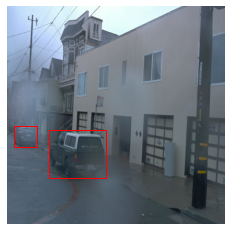

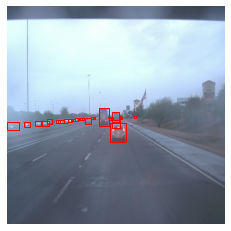

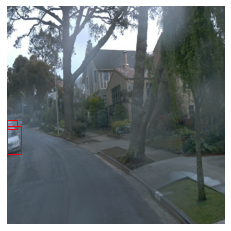

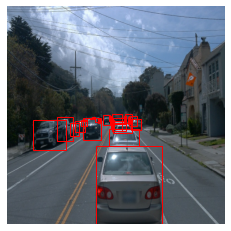

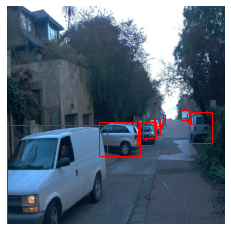

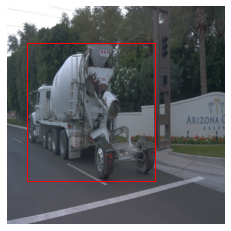

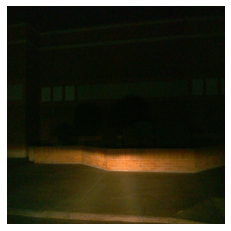

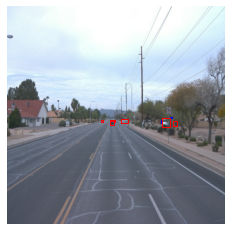

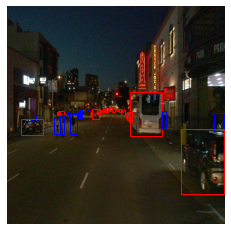

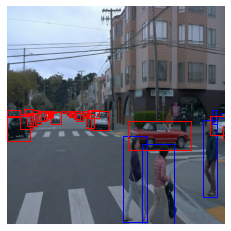

In [4]:
display_instances(dataset.shuffle(75, reshuffle_each_iteration=True).take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [10]:
class_to_num_mapping = {
    "TYPE_UNKNOWN": 0,
    "TYPE_VEHICLE": 1,
    "TYPE_PEDESTRIAN": 2,
    "TYPE_SIGN": 3,
    "TYPE_CYCLIST": 4,
}

num_to_class = {v:k for k,v in class_to_num_mapping.items()}

In [29]:
labels_counter = collections.Counter()

SAMPLE_SIZE = 10000

for batches in tqdm.tqdm(dataset.take(SAMPLE_SIZE), total=SAMPLE_SIZE):
    labels_counter.update(batches["groundtruth_classes"].numpy())

100%|█████████████████████████████████████████████| 10000/10000 [00:15<00:00, 648.78it/s]


In [41]:
sns.set_palette("pastel")
sns.color_palette()

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

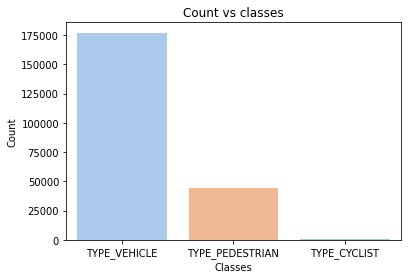

In [42]:
import seaborn as sns

X = list()
y = list()

for k, v in labels_counter.items():
    X.append(num_to_class[k])
    y.append(v)

ax = sns.barplot(x=X, y=y)
ax.set(xlabel='Classes', ylabel='Count', title='Count vs classes')
plt.show()

# Print files distribution

In [4]:
files = [filename for filename in glob.glob(f'datasets/data_dir/processed/*.tfrecord')]

In [29]:
np.random.shuffle(files)

# spliting files
train_files, val_file, test_file = np.split(files, [int(.75*len(files)), int(.9*len(files))])


In [33]:
data_dir = pathlib.Path("datasets/data_dir")

In [31]:
print("train_files", len(train_files))
print("val_file", len(val_file))
print("test_file", len(test_file))

train_files 25
val_file 5
test_file 4


In [38]:
train_path = data_dir / "train"
val_path = data_dir / "val"
test_path = data_dir / "test"

clean_targets(train_path)
clean_targets(val_path)
clean_targets(test_path)

train_path.mkdir(exist_ok=True)
val_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

def clean_targets(target):
    if target.exists():
        shutil.rmtree(target)

def hardlink(files, target_path):
    for file in files:
        target = pathlib.Path(file)
        target.link_to(target_path / target.name)

hardlink(train_files, train_path)
hardlink(val_file, val_path)
hardlink(test_file, test_path)
